# Notes:

This notebook plots the free parameters which are used by the Zhang+20 fit vs redshift. It figures out how to extrapolate them to plot a similar curve for any redshift.
ZHANG FIT ARCHIVE:
PAPERS: Zhang+20: https://arxiv.org/abs/2011.14494

# Imports

In [305]:
import numpy as np
from frb.dm import igm
from matplotlib import pyplot as plt
from scipy import interpolate
import matplotlib.cm as cm
import matplotlib
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t
import scipy.stats as stats

# Functions

-0.02959326


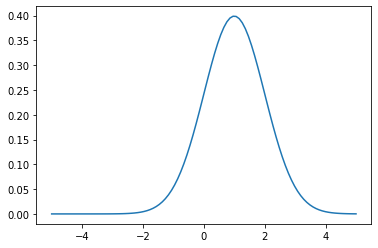

In [329]:
x= np.linspace(-5,5,100)
mean=1
std=1
plt.plot(x,stats.norm.pdf(x,mean,std))

a,b,c = [0.17408489,-0.02959326,0.08146239]
print(b)

# Zhang fitting parameters

In [125]:
### redshift
z = [0.1,
     0.2,
     0.3,
     0.4,
     0.5,
     0.7,1.0,1.5,2.0,2.4,3.0,3.5,4.0,4.4,5.0,5.2,5.5,5.8,6.0,6.5,7.0,8.0,9.0]

#A
A = [0.04721,
     0.005693,
     0.003584,
     0.002876,
     0.002423,
     0.001880,
     0.001456,
     0.001098,
     0.0009672,
     0.0009220,
     0.0008968,
     0.0008862,
     0.0008826,
     0.0008827,0.0008834,0.0008846,0.0008863,0.0008878,0.0008881,0.0008881,0.0008881,0.0008881,0.0008881]

#C0
C0 = [-13.17,
      -1.008,
      0.596,
      1.010,
      1.127,
      1.170,
      1.189,
      1.163,
      1.162,
      1.142,
      1.119,
      1.104,
      1.092,
      1.084,
      1.076,1.073,1.070,1.067,1.066,1.066,1.066,1.066,1.066]



#sigmaDM
sigmaDM = [2.554,
           1.118,
           0.7043,
           0.5158,
           0.4306,
           0.3595,
           0.3044,
           0.2609,
           0.2160,
           0.1857,
           0.1566,
           0.1385,
           0.1233,
           0.1134,
           0.1029,
           0.09918,0.09481,0.09072,0.08971,0.08960,0.08952,0.08944,0.08941]

# Linear interpolation functions

In [126]:
#functions which generate fitting parameters by linearly interpolating zhang values

#A
linterp_A = interpolate.interp1d(z,A)

#C0
linterp_C0 = interpolate.interp1d(z,C0)

#sigmaDM
linterp_sigmaDM = interpolate.interp1d(z,sigmaDM)

# Better interpolation functions

In [342]:
#asyptotic form and curve fit from: 
#https://stackoverflow.com/questions/45554107/asymptotic-regression-in-python
#michaelis-menten equation function from:
#https://www.statforbiology.com/nonlinearregression/usefulequations
#reciprocal function link:
#https://study.com/academy/lesson/reciprocal-functions-definition-examples-graphs.html
#and initial parameters found by fiddling with them on wolfram alpha

def asymp_f(x, a, b, n):
    return a * x ** n  / (x ** n + b)

def mm_f(x,a,b):
    return (a*x)/(b+x)

def asymptote_func(x,a,b,c):
    """
    Asymptotic function for fitting A, sigmaDM
    
    """
    return (a/(x+b))+c

def horizontal_asymptote_func(x,a,b,c,d):
    """
    Horizontal asymptote for fitting C0
    """
    return ((a*x)+b)/((c*x)+d)

def oblique_asymptote_func(x,a,b,c):
    """
    Oblique asymptote for fitting C0
    Inspiration: 
    https://math.stackexchange.com/questions/3420495/finding-the-equation-of-a-hyperbola-that-has-two-arbitrary-intersecting-lines-as/3420564
    form which gives kind of right shape: (-x+a)(y-b)=c
    when b=2 it tends to around the right y value
    when a=0.01 it looks fairly close to the right x value
    """
    return (c/(a-x)) + b

def straight_line_func(x,a,b):
    """
    function to fit straight lines
    two straight lines will be fit to C0 data
    an oblique function will be fit to these straight lines
    """    
    return (a*x)+b

def osl_func(x,a,b,c,d,k):
    """
    From: https://math.stackexchange.com/questions/3420495/finding-the-equation-of-a-hyperbola-that-has-two-arbitrary-intersecting-lines-as/3420564
    the oblique hyperbola between two straight lines y=ax+b and y=cx+d will be: (ax+b-y)(cx+d-y)=k
    rearrange this with wolfram alpha to:
    y = 1/2 (-sqrt((-a x - b - c x - d)^2 - 4 (a c x^2 + a d x + b c x + b d - k)) + a x + b + c x + d)

    this is the equation which should be fitted.
    """
    return (1./2)*(-1*np.sqrt(((-a*x) - b - (c*x) - d)**2 - 4*((a*c*(x**2)) + (a*d*x) + (b*c*x) + (b*d) - k)) + (a*x) + b + (c*x) + d)


def ga_func(x,mean,std,shift):
    """
    Gaussian multiplied by asymptotic function for fitting sigmaDM
    perhaps needs convolutin?
    
    """
    
    a,b,c = [0.17408489,-0.02959326,0.08146239]
    
    asymptote = (a/(x+b))+c
    gaussian = stats.norm.pdf(x,mean,std)
    #shift up gaussian
    gaussian+=shift
    
    #plt.plot(x,asymptote,lw=10)
    
    #plt.plot(x,gaussian*asymptote,alpha=0.1)
    
    return asymptote*gaussian

##fitting c0
#
#asymp_popt, asymp_pcov = curve_fit(asymp_f, z, C0, p0=[2., .5, 1])
#
#mm_popt,mm_pcov = curve_fit(mm_f,z,C0,p0=[-5,6.])
#                            
#plt.scatter(z,C0)
#plt.plot(z, asymp_f(z, *asymp_popt), 'r-')
#plt.plot(z, mm_f(np.array(z), *mm_popt), 'k-')

###########
#fitting A#
###########

A_p0   = [1,1,1] #initial parameters
data_x = z       #x-data (redshifts)
data_y = A       #y-data (A values)

A_p_new, Afit_pcov = curve_fit(asymptote_func,data_x,data_y,p0=A_p0) #calculate new parameters


#################
#fitting sigmaDM#
#################

sigmaDM_p0   = [1,1,1] #initial parameters
data_x = z       #x-data (redshifts)
data_y = sigmaDM       #y-data (A values)

sigmaDM_p_new, sigmaDMfit_pcov = curve_fit(asymptote_func,data_x,data_y,p0=sigmaDM_p0) #calculate new parameters

print(sigmaDM_p_new)

sigmaDM_p0_2   = [1,100,0.5] #initial parameters
data_x_2 = z       #x-data (redshifts)
data_y_2 = sigmaDM       #y-data (A values)

sigmaDM_p_new_2, sigmaDMfit_pcov_2 = curve_fit(ga_func,data_x_2,data_y_2,p0=sigmaDM_p0_2) #calculate new parameters

print(sigmaDM_p_new)

############
#fitting C0#
############

#horizontal asymptote
C0_p0   = [3,5,1,2] #initial parameters
data_x = z       #x-data (redshifts)
data_y = C0       #y-data (A values)

C0_p_new, C0fit_pcov = curve_fit(horizontal_asymptote_func,data_x,data_y,p0=C0_p0) #calculate new parameters


#oblique asymptote
C0_p0_oblique   = [0.01,2,1] #initial parameters
data_x_oblique = z       #x-data (redshifts)
data_y_oblique = C0       #y-data (A values)

C0_p_new_oblique, C0fit_pcov_oblique = curve_fit(oblique_asymptote_func,data_x_oblique,data_y_oblique,p0=C0_p0_oblique) #calculate new parameters

#linear then oblique

#fit first straight line
C0_p0_1   = [1,1] #initial parameters
data_x_1 = z[0:4]       #x-data (redshifts)
data_y_1 = C0[0:4]       #y-data (A values)

C0_p_new_1, C0fit_pcov_1 = curve_fit(straight_line_func,data_x_1,data_y_1,p0=C0_p0_1) #calculate new parameters

#fit second straight line
C0_p0_2   = [1,1] #initial parameters
data_x_2 = z[7:]       #x-data (redshifts)
data_y_2 = C0[7:]       #y-data (A values)

C0_p_new_2, C0fit_pcov_2 = curve_fit(straight_line_func,data_x_2,data_y_2,p0=C0_p0_2) #calculate new parameters

#fit the hyperbola from the lines

C0_p0_3   = [C0_p_new_1[0],
             C0_p_new_1[1],
             C0_p_new_2[0],
             C0_p_new_2[1],1] #initial parameters (from straight line results)

data_x_3 = z       #x-data (redshifts)
data_y_3 = C0       #y-data (A values)

C0_p_new_3, C0fit_pcov_3 = curve_fit(osl_func,data_x_3,data_y_3,p0=C0_p0_3) #calculate new parameters


[ 0.17408489 -0.02959326  0.08146239]
[ 0.17408489 -0.02959326  0.08146239]


# Plots

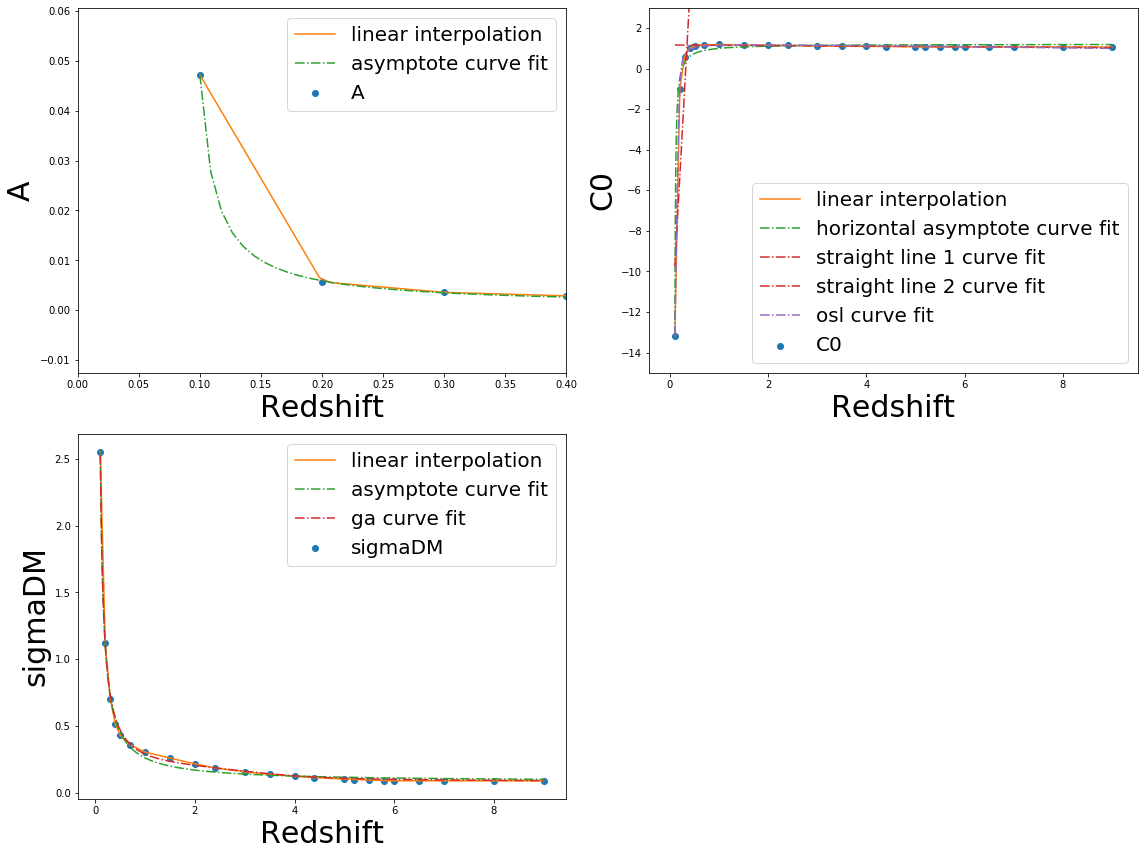

In [344]:

fig = plt.figure(figsize=(16,12))

#array of redshifts to test interpolation methods
interp_test_z = np.linspace(0.1,9.0,1000)
#print(interp_test_z)

ax1  = fig.add_subplot(221)
ax2  = fig.add_subplot(222)
ax3  = fig.add_subplot(223)

ax1.set_xlabel('Redshift',fontsize=30)
ax1.set_ylabel('A',fontsize=30)
ax1.set_xlim([0,0.4])
ax1.scatter(z,A,label='A')
ax1.plot(interp_test_z,linterp_A(interp_test_z),color='C1',label='linear interpolation')
ax1.plot(interp_test_z,asymptote_func(interp_test_z,*A_p_new),color='C2',ls='-.',label='asymptote curve fit')
ax1.legend(fontsize=20)

ax2.set_xlabel('Redshift',fontsize=30)
ax2.set_ylabel('C0',fontsize=30)
ax2.set_ylim([-15,3])
ax2.plot(interp_test_z,linterp_C0(interp_test_z),color='C1',label='linear interpolation')
ax2.scatter(z,C0,label='C0')
ax2.plot(interp_test_z,horizontal_asymptote_func(interp_test_z,*C0_p_new),color='C2',ls='-.',label='horizontal asymptote curve fit')
#ax2.plot(interp_test_z,oblique_asymptote_func(interp_test_z,*C0_p_new_oblique),color='C4',ls='-.',label='oblique asymptote curve fit')
ax2.plot(interp_test_z,straight_line_func(interp_test_z,*C0_p_new_1),color='C3',ls='-.',label='straight line 1 curve fit')
ax2.plot(interp_test_z,straight_line_func(interp_test_z,*C0_p_new_2),color='C3',ls='-.',label='straight line 2 curve fit')
ax2.plot(interp_test_z,osl_func(interp_test_z,*C0_p_new_3),color='C4',ls='-.',label='osl curve fit')

ax2.legend(fontsize=20)

ax3.set_xlabel('Redshift',fontsize=30)
ax3.set_ylabel('sigmaDM',fontsize=30)
ax3.scatter(z,sigmaDM,label='sigmaDM')
ax3.plot(interp_test_z,linterp_sigmaDM(interp_test_z),color='C1',label='linear interpolation')
ax3.plot(interp_test_z,asymptote_func(interp_test_z,*sigmaDM_p_new),color='C2',ls='-.',label='asymptote curve fit')
ax3.plot(interp_test_z,ga_func(interp_test_z,*sigmaDM_p_new_2),color='C3',ls='-.',label='ga curve fit')

ax3.legend(fontsize=20)

plt.tight_layout()
plt.savefig('zhang_fitting_parameters.png',format='png')

# Function to recreate zhang distribution

In [128]:
def zhang_distribution(DM_arr,redshift,interp_method='linterp'):
    """
    
    Function which calculates the Zhang+20 pIGM Zhang probability
    distribution for a desired DM range at a desired redshift.
    
    Distribution is Equation 10 in https://arxiv.org/abs/2011.14494
    
    Requires FRB python package from github
    
    INPUTS:
    
    DM_arr        : [array of floats] array of dispersion measures (in pc/cc)
                    to get the distribution for.
    redshift      : [float] redshift to calculate probability distribution for.
    interp_method : [str] if 'linterp', uses linear interpolation to calculate
                    fitting parameters
                    
    RETURNS:
    
    pIGM          : [array of floats] array of probabilities.
    
    """
    
    ##################################
    #calculate the fitting parameters#
    ##################################
    
    if interp_method == 'linterp': #via linear interpolation
        A = linterp_A(redshift)
        C0 = linterp_C0(redshift)
        sigmaDM = linterp_sigmaDM(redshift)
        #print('A={0}, C0={1}, sigmaDM={2}'.format(A,C0,sigmaDM))
        
    else:
        print('Error: invalid interpolation method')
        return
    
    #################
    #calculate Delta#
    #################
    
    average_DMIGM = igm.average_DM(redshift) #theoretical average DM for this redshift from Macquart relation
    average_DMIGM = average_DMIGM.value
    
    Delta = np.array(DM_arr)/average_DMIGM
    
    #######################
    #Calculate probability#
    #######################
    
    alpha = 3 #from zhang+20
    beta = 3 #from zhang+20
    
    amplitude = A * (Delta**(-1*beta))
    #print(amplitude)
    
    exponent_numerator  = -1*(((Delta**(-1*alpha))-C0)**2)
    #print(exponent_numerator)
    
    exponent_denominator = (2*alpha**2*sigmaDM**2)
    #print(exponent_denominator)
    
    exponent = exponent_numerator/exponent_denominator
    #print(exponent)
    
    pIGM = amplitude * np.exp(exponent)
    
    return pIGM

# Plot curves for just full snapshots (as a check) and curves between snapshots

## For linear interpolation method

/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launche

/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launche

/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launche

/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launche

/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launche

/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launche

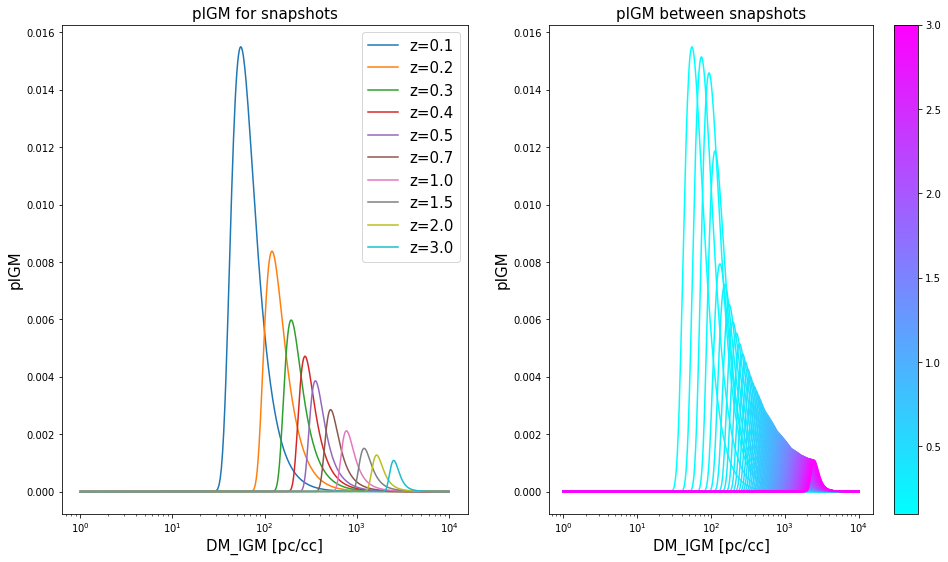

In [294]:
############
#Initialise#
############

DM_list = np.linspace(0,10000,10000) #list of DMs to get probability for
interp_method = 'linterp' #interpolation method to be used when ceating probability distributions

############
#Plot setup#
############

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(121)
ax1.set_title('pIGM for snapshots',fontsize=15)
ax1.set_xlabel('DM_IGM [pc/cc]',fontsize=15)
ax1.set_ylabel('pIGM',fontsize=15)
ax1.set_xscale('log')

ax2 = fig.add_subplot(122)
ax2.set_title('pIGM between snapshots',fontsize=15)
ax2.set_xlabel('DM_IGM [pc/cc]',fontsize=15)
ax2.set_ylabel('pIGM',fontsize=15)
ax2.set_xscale('log')

####################
#plot for snapshots#
####################

for redshift in [0.1,0.2,0.3,0.4,0.5,0.7,1.0,1.5,2.0,3.0]: #loop over snapshot redshifts
    p=zhang_distribution(DM_list,redshift,interp_method) #get probability distribution
    ax1.plot(DM_list,p,label='z={0}'.format(redshift)) #plot
ax1.legend(fontsize=15)

########################
#plot between snapshots#
########################

nlines=100 #number of curves to plot
redshift_arr = np.linspace(0.1,3.0,nlines) #array of nlines redshifts which will be plotted

###############
#colorbar code#
###############
#note: from https://stackoverflow.com/questions/26545897/drawing-a-colorbar-aside-a-line-plot-using-matplotlib
mycmap = cm.cool # desired colormap
#code to make sure each line has a unique color on the colorbar
norm = matplotlib.colors.Normalize(vmin=np.min(redshift_arr),vmax=np.max(redshift_arr)) 
s_m = cm.ScalarMappable(cmap=mycmap, norm=norm)
s_m.set_array([])

######
#plot#
######

for i in range(len(redshift_arr)): #loop over redshifts
    redshift = redshift_arr[i] #get redshift to create distribution for
    color = s_m.to_rgba(redshift_arr[i]) #get color of this line
    p=zhang_distribution(DM_list,redshift,interp_method) #get probability distribution
    plot = ax2.plot(DM_list,p,color=color) #plot
plt.colorbar(s_m)

plt.savefig('Interpolated_pIGM_{0}_method.png'.format(interp_method),format='png')
plt.show()

In [75]:
print(np.arange(10)-1)

[-1  0  1  2  3  4  5  6  7  8]
